In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 데이터셋 준비

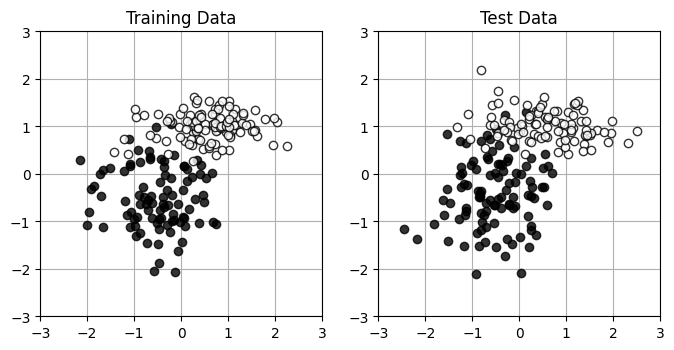

In [39]:
np.random.seed(seed=1) # 난수를 고정
N = 400 # 데이터의 수
K = 2 # 분포의 수
Y = np.zeros((N, 2), dtype=np.uint8) # 분류목적으로 target은 One-hot encoding 방식으로 표현 1->[1,0], 2->[0,1]
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-0.5, -0.5], [0.5, 1.0]]) # 분포의 중심, [X1 평균값, X2 평균값]으로 하나의 중심을 표현
Sig = np.array([[0.7, 0.7], [0.8, 0.3]]) # 분포의 분산 (정확히는 표준편차)
Pi = np.array([0.5, 1.0]) # 각 분포에 대한 비율, 0 ~ 0.5 -> Class 0, 0.5 ~ 1.0 -> Class 1
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            Y[n, k] = 1 # Pi 비율을 참조하여 target 값 결정
            break
    # 가우시안 샘플링
    for k in range(K): 
        X[n, k] = np.random.randn() * Sig[Y[n, :] == 1, k] + Mu[Y[n, :] == 1, k] # 랜덤값 * 분산 + 평균값(이동)


# -------- 2 분류 데이터를 테스트 훈련 데이터로 분할
YestRatio = 0.5
X_n_training = int(N * YestRatio)
X_train = X[:X_n_training]
X_test = X[X_n_training:]
Y_train = Y[:X_n_training]
Y_test = Y[X_n_training:]


# -------- 데이터를 'class_data.npz'에 저장
#np.savez('class_data.npz', X_train=X_train, Y_train=Y_train,
#         X_test=X_test, Y_test=Y_test,
#         X_range0=X_range0, X_range1=X_range1)

# 결정 경계 시각화 함수
def Show_MLP_Contour(U1, U2, P, C):
    xn = 60 #등고선 표시 해상도
    x0 = np.linspace(X_range0[0],X_range0[1], xn)
    x1 = np.linspace(X_range1[0],X_range1[1], xn)
    xx0,xx1 = np.meshgrid(x0,x1)
    x = np.c_[np.reshape(xx0,xn*xn), np.reshape(xx1,xn*xn)]
    output, _, _, _ = MLP_forward(U1,U2,P,C,x)
    plt.figure(1, figsize=(4,4))
    for ic in range(C):
        f = output[:,ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1) 

# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, Y_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, Y_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()


# 활성화 함수, MLP, 손실 함수 정의

In [40]:

# 시그모이드 함수 ------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def deriv_Sigmoid(x):
    return x * (1 -x)

def MLP_forward(U1, U2, P, C, x):
    N, D = x.shape #입력 차원
    
    zsum = np.zeros((N,P+1))
    z = np.zeros((N,P+1))
    osum = np.zeros((N,C))
    o = np.zeros((N,C))
    
    for n in range(N):
        #은닉층의 계산
        zsum[n,0] = 1.0
        z[n,0] = 1.0
        #for j in range(P):
        #    zsum[n, j+1] = np.dot(U1[j],np.r_[1,x[n]])
        #    z[n,j+1] = Sigmoid(zsum[n, j+1])
        # 순환문 아래의 행렬식으로 가능
        zsum[n,1:] = np.dot(U1, np.r_[1, x[n]])
        z[n] = Sigmoid(zsum[n])
        
        #출력층 계산
        #for k in range(C):
        #    osum[n, k] = np.dot(U2[k],z[n])
        #    o[n,k] = Sigmoid(osum[n, k])
        # 순환문 아래의 행렬식으로 가능
        osum[n] = np.dot(U2, z[n])
        o[n] = Sigmoid(osum[n])
        
    return o, osum, z, zsum

def MLP_backward(U1, U2, P, C, x, y):
    N, D = x.shape #입력 차원
    dU1 = np.zeros_like(U1)
    dU2 = np.zeros_like(U2)
    delta = np.zeros(C)
    eta = np.zeros(P)    
    
    o, _, z, _ = MLP_forward(U1,U2,P,C,x)
    #x0 = np.ones((N,1))
    #x = np.concatenate([x0,x], axis=1)
    for n in range(N):
        # 출력층 node의 입력에서 에러값 delta 계산
        #for k in range(C):
        #    delta[k] = (y[n,k]-o[n,k])*o[n,k]*(1-o[n,k])
        # 순환문 아래의 행렬식으로 가능
        delta = (y[n] - o[n])*deriv_Sigmoid(o[n])
        
        # 은닉층 node의 입력에서 에러값 eta 계산
        sum_err = np.zeros_like(eta)
        #for j in range(P):
        #    for k in range(C):
        #        sum_err[j] = sum_err[j] + U2[k,j+1]*delta[k] #은닉층 j번째 node의 출력에 유입되는 에러값을 계산
        #    eta[j] = z[n,j+1]*(1-z[n,j+1])*sum_err[j] #은닉층 j번째 node의 입력의 에러값 계산
        # 순환문 아래의 행렬식으로 가능
        sum_err = np.dot(U2.T[1:], delta)
        eta = sum_err * deriv_Sigmoid(z[n, 1:])

        
        # 출력 node와 은닉층 node를 연결하는 edge의 weight 미분값을 계산       
        #for k in range(C):
        #    for j in range(P+1):
        #        dU2[k,j] = dU2[k,j] - z[n,j]*delta[k]/N # 배치 단위의 delta를 더한 후에 N으로 나눠 평균값을 사용
        # 순환문 아래의 행렬식으로 가능
        dU2 = dU2 - np.dot( delta.reshape((-1, 1,)), z[n].reshape((1, -1)) )/N
                
        # 은닉층 node와 입력층 node를 연결하는 edge의 weight 미분값을 계산
        x_ = np.r_[1,x[n]]
        #for j in range(P):
        #    for i in range(D+1):
        #        dU1[j,i] = dU1[j,i] - x_[i]*eta[j]/N
        # 순환문 아래의 행렬식으로 가능
        dU1 = dU1 - np.dot( eta.reshape((-1, 1,)), x_.reshape((1, -1)) )/N

    return dU1, dU2


# Loss func
def mse_cal(U1, U2, P, C, X, Y):
    N, D = X_test.shape
    output, _, _, _ = MLP_forward(U1, U2, P, C, X)
    mse = np.square(Y.reshape(-1)- output.reshape(-1)).mean()
    return mse

# 하이퍼파라미터 설정 및 학습

In [41]:
# test ---
P = 2
C = 2
D = 2

np.random.seed(seed=100)
U1 = np.random.randn(P*(D+1))
U1 = U1.reshape(P,D+1)
U2 = np.random.randn(C*(P+1))
U2 = U2.reshape(C,P+1)

rho = 0.01 # learning rate
epoch = 300 # 2000(>= 2000 배치크기가 32일때)
N, D = X_train.shape #training dataset size
batch_size = 1 # batch_size = 1 will be Stochastic method!!!
batch_num = X_train.shape[0] // batch_size
sIdx = np.arange(X_train.shape[0])
error_train = []
error_test = []
startTime = time.time()
for e in range(epoch):
    print(f"The number of Epoch:{e:04d}\n")
    
    np.random.shuffle(sIdx)    #training dataset X_train와 Y_train를 같은 순번으로 shuffing시킴
    X_train = X_train[sIdx]
    Y_train = Y_train[sIdx]
    
    for n in range(batch_num):
        if(n < (batch_num-1)):
            #dU1, dU2 = MLP_backward(U1, U2, P, C, X_train[n:n+batch_size], Y_train[n:n+batch_size])
            dU1, dU2 = MLP_backward(U1, U2, P, C, X_train[n*batch_size:n*batch_size+batch_size], Y_train[n*batch_size:n*batch_size+batch_size])
        else:
            #dU1, dU2 = MLP_backward(U1, U2, P, C, X_train[n:], Y_train[n:])
            dU1, dU2 = MLP_backward(U1, U2, P, C, X_train[n*batch_size:], Y_train[n*batch_size:])
        
        # U2 행렬을 업데이트               
        #for k in range(C):
        #    for j in range(P+1):
        #        U2[k,j] = U2[k,j] - rho*dU2[k,j]
        #위의 순환문 대신 아래의 한줄로 연산 가능
        U2 = U2 -rho*dU2
        
        #U1 행렬을 업데이트
        #for j in range(P):
        #    for i in range(D+1):
        #        U1[j, i] = U1[j,i] - rho*dU1[j,i]
        #위의 순환문 대신 아래의 한줄로 연산 가능
        U1 = U1 -rho*dU1                
    
    e_train = mse_cal(U1, U2, P, C, X_train, Y_train)
    e_test = mse_cal(U1, U2, P, C, X_test, Y_test)
    error_train.append(e_train)
    error_test.append(e_test)

    print(f"Updated U1 Matrix in learning process:\n {U1}\n")
    print(f"Updated U1 Matrix in learning process:\n {U2}\n")
    print("###########################\n")

calculation_time = time.time() - startTime
print(f"Calculation time:{calculation_time:0.3f} sec\n")

print(f"Final Updated U1 Matrix:{U1}\n")
print(f"Final Updated U1 Matrix:{U2}\n")


The number of Epoch:0000

Updated U1 Matrix in learning process:
 [[-1.74156535  0.35273795  1.16734867]
 [-0.25419243  0.99273109  0.53456647]]

Updated U1 Matrix in learning process:
 [[ 0.23207714 -1.09927038 -0.22354762]
 [ 0.24060577 -0.42519481  0.47268493]]

###########################

The number of Epoch:0001

Updated U1 Matrix in learning process:
 [[-1.73286299  0.36349199  1.18277968]
 [-0.25629932  1.00475663  0.55636766]]

Updated U1 Matrix in learning process:
 [[ 0.24467462 -1.12807172 -0.25657293]
 [ 0.22498765 -0.39242189  0.50975739]]

###########################

The number of Epoch:0002

Updated U1 Matrix in learning process:
 [[-1.72373014  0.37487941  1.1992092 ]
 [-0.25870235  1.01731047  0.57935843]]

Updated U1 Matrix in learning process:
 [[ 0.25883185 -1.15646228 -0.28864695]
 [ 0.20833479 -0.35963096  0.54652585]]

###########################

The number of Epoch:0003

Updated U1 Matrix in learning process:
 [[-1.71425105  0.38689402  1.21657509]
 [-0.26158

# 테스트 데이터셋으로 평가

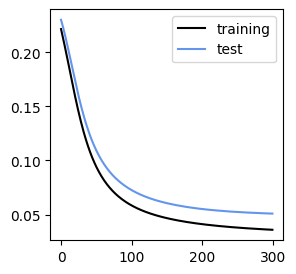

In [42]:
plt.figure(1,figsize=(3,3))
plt.plot(error_train, 'black', label='training')
plt.plot(error_test,'cornflowerblue', label='test')
plt.legend()
plt.show()

# 학습이 끝난 후 inference 과정, 모델 평가
infer_train, _, _, _ = MLP_forward(U1,U2,P,C,X_train)
infer_test, _, _, _ = MLP_forward(U1,U2,P,C,X_test)

# 확률값이 더 큰 값을 갖게 하는 인덱스를 계산하여 부류를 결정, axis=1 -> 샘플마다 argmax 수행
maxOutputIndex_train = np.argmax(infer_train, axis=1)
maxOutputIndex_test = np.argmax(infer_test, axis=1)

# One-hot 인코딩 표현으로 변환 및 예측한 부류값 추출

In [43]:
# 원핫 인코딩 표현으로 변환
# 아래의 Identity matrix에서 행을 선택하여 one-hot encoding으로 변환
#[[1 0],
# [0 1]]
onehotOutput_train = np.eye(Y_train.shape[1])[maxOutputIndex_train] # '0' class -> [1,0], '1' class -> [0,1]
onehotOutput_test = np.eye(Y_train.shape[1])[maxOutputIndex_test]

maxTargetIndex_train = np.argmax(Y_train, axis=1)
maxTargetIndex_test = np.argmax(Y_test, axis=1)

accuracy for training dataset:0.965

accuracy for test dataset:0.935



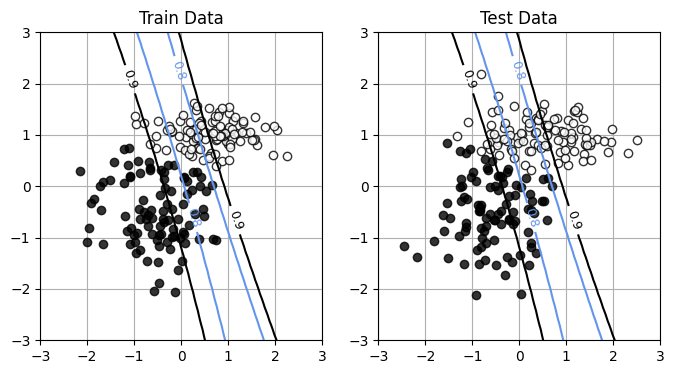

In [44]:
correct_num = 0.0
for n in range(X_train.shape[0]):
    if(maxTargetIndex_train[n] == maxOutputIndex_train[n]):
        correct_num += 1.0
accuracy_train = correct_num/X_train.shape[0]

correct_num = 0.0
for n in range(X_test.shape[0]):
    if(maxTargetIndex_test[n] == maxOutputIndex_test[n]):
        correct_num += 1.0
accuracy_test = correct_num/X_test.shape[0]

print(f'accuracy for training dataset:{accuracy_train}\n')
print(f'accuracy for test dataset:{accuracy_test}\n')


plt.figure(1, figsize=(8,4))
plt.subplot(1,2,1)
Show_data(X_train,onehotOutput_train)
Show_MLP_Contour(U1, U2, P, C)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Train Data')
plt.subplot(1,2,2)
Show_data(X_test, onehotOutput_test)
Show_MLP_Contour(U1, U2, P, C)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()